In [1]:
import os
import re
import pywt
import glob
import joblib
import numpy as np
import pandas as pd 
from scipy import interpolate

from sklearn.preprocessing import StandardScaler

import torch

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

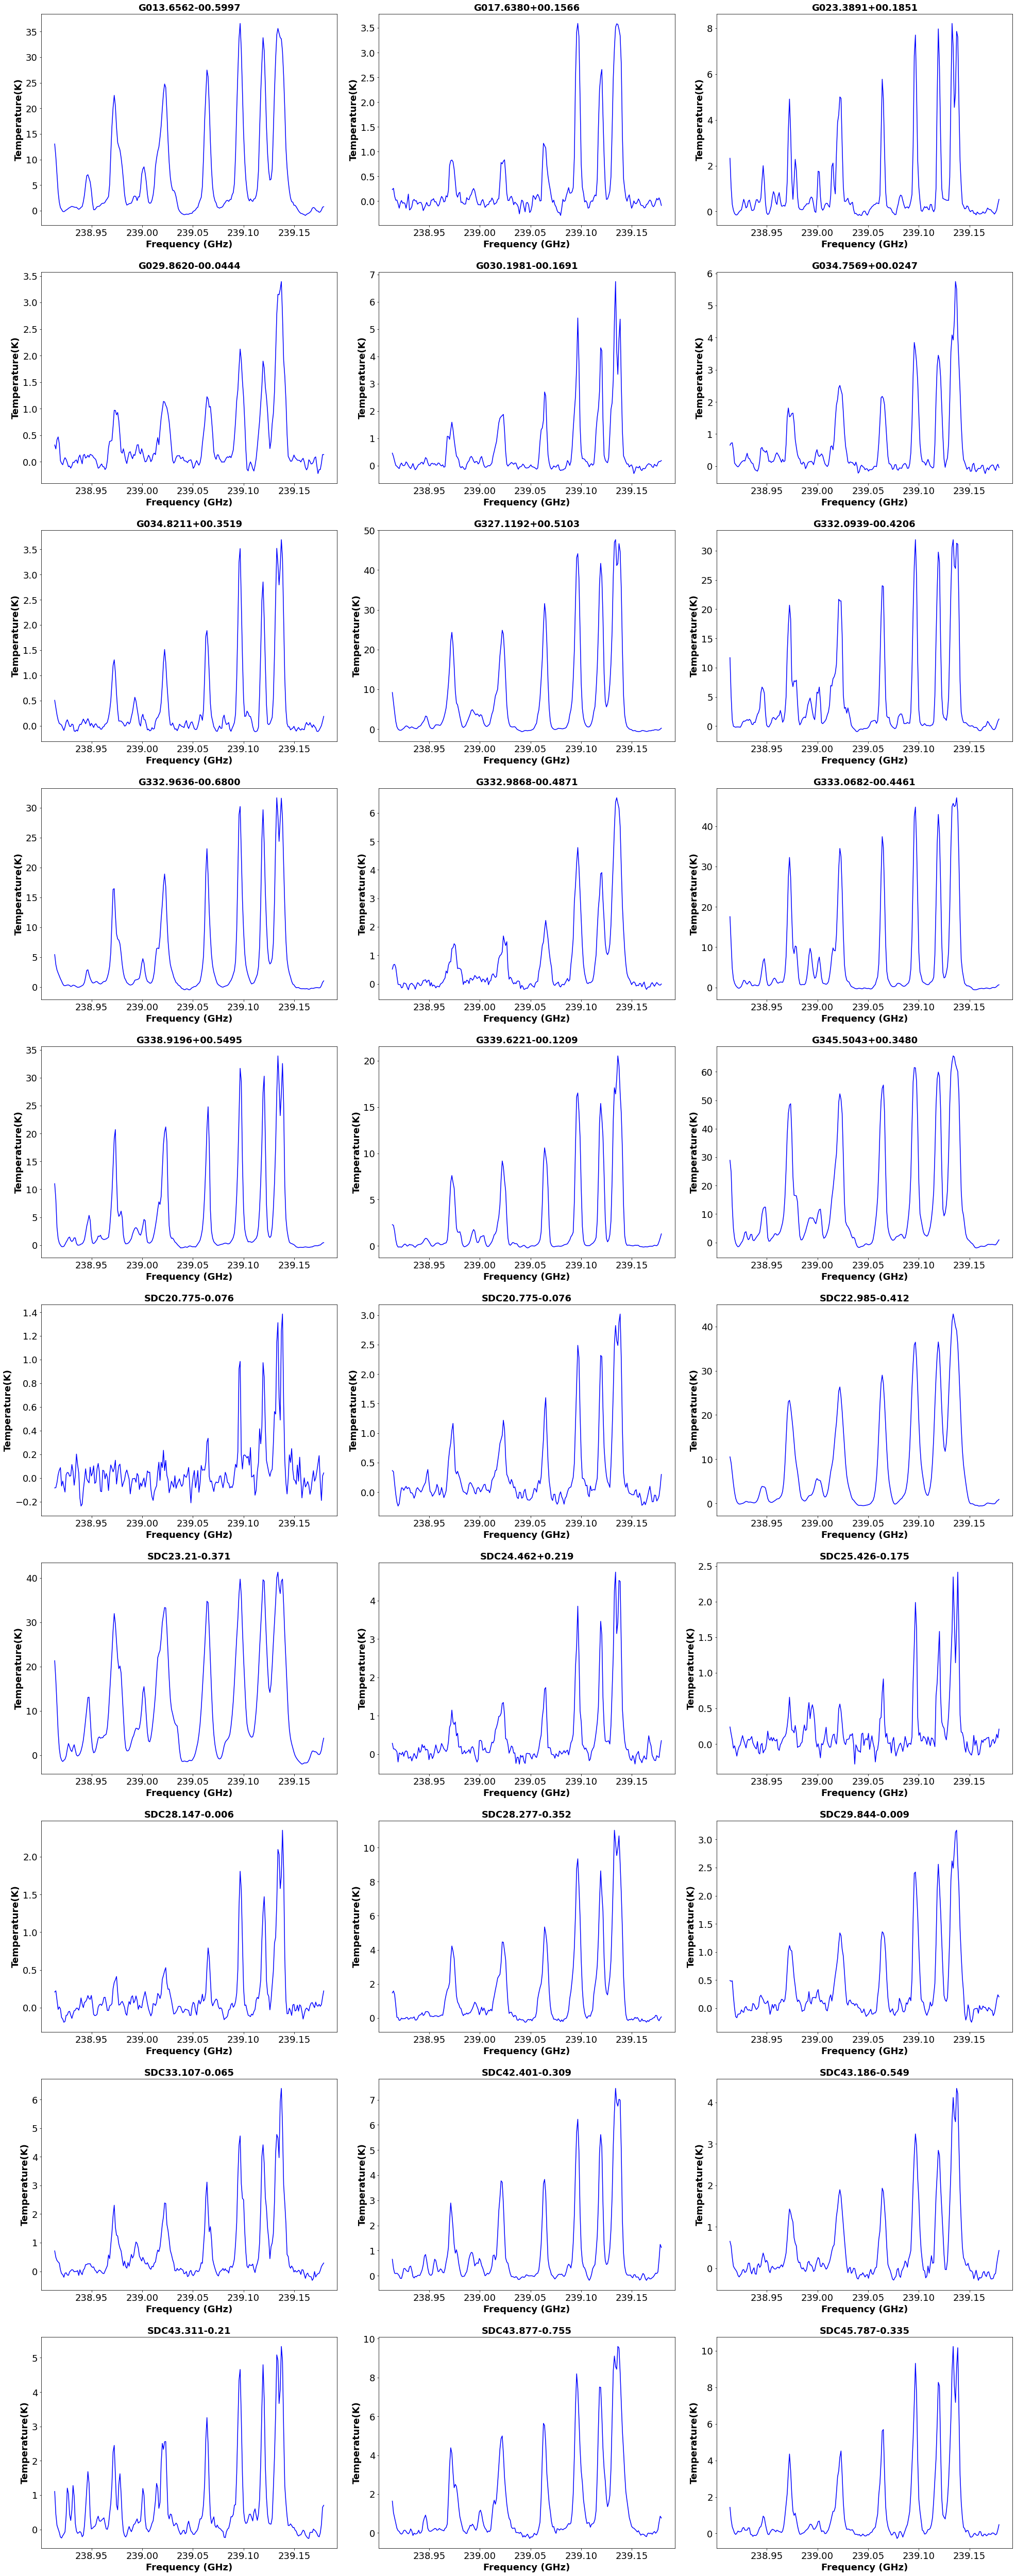

In [2]:
CH3CN_DATA_PATH = '../data/observational/ch3cn_spec/'
CH3CH_DATA_OUTPUT_PATH = '../data/observational/ch3cn_output/'
C3CHN_GENERATED_FILES_OUTPUT_PATH = '../data/observational/ch3cn_generated_files/'

# open the file in the data path
# df_ch3cn = pd.read_csv(ch3cn_data_path + 'G017.6380+00.1566_SPW_0_p_spec.dat', delim_whitespace=True)

unwanted_file_list = ['G050.2213-00.6063_SPW_0_p_spec.dat', 'G326.6618+00.5207_SPW_0_p_spec.dat', 'SDC24.381-0.21_3_SPW_0_p_spec.dat', 
                'SDC18.816-0.447_1_SPW_0_p_spec.dat', 'SDC35.063-0.726_1_SPW_0_p_spec.dat', 'SDC45.927-0.375_2_SPW_0_p_spec.dat', 
                'SDC37.846-0.392_1_SPW_0_p_spec.dat', 'SDC30.172-0.157_2_SPW_0_p_spec.dat',  'SDC18.816-0.447_1_SPW_0_p_spec.dat'               
]

def plot_observational_data(CH3CN_DATA_PATH):
    ch3cn_files = sorted(glob.glob(CH3CN_DATA_PATH + '*.dat'), key=lambda x: int(re.search(r'\d+', x).group()))
    # drop files whose intensity column highest value is in the range of [0, 0.6]
    # ch3cn_files = [file for file in ch3cn_files if float(pd.read_csv(file, delim_whitespace=True, nrows=1).iloc[0, -2]) > 0.5]
    # drop the files in the unwanted_files list
    ch3cn_files = [file for file in ch3cn_files if os.path.basename(file) not in unwanted_file_list]
 
    # plot the observational data of the first 15 files
    fig, ax = plt.subplots(nrows=10, ncols=3, figsize=(28, 70))
    fig.tight_layout(pad=5, w_pad=5, h_pad=7)

    # read the dat for all the files in the directory
    for axn,file in zip(ax.flatten(), sorted(ch3cn_files)):
        df_ch3cn = pd.read_csv(file, delim_whitespace=True)
        df_ch3cn.drop(df_ch3cn.columns[-1], axis=1, inplace=True)
        df_ch3cn.columns = ['RestFreq(Hz)', 'T(K)']
        # convert the RestFreq(Hz) to GHz
        df_ch3cn['RestFreq(GHz)'] = df_ch3cn['RestFreq(Hz)'] / 1e9
        # get the start and end frequencies to be 238.91 and 239.18 GHz
        df_ch3cn = df_ch3cn[(df_ch3cn['RestFreq(GHz)'] >= df_ch3cn['RestFreq(GHz)'].min()) & (df_ch3cn['RestFreq(GHz)'] <= 239.180)]

        #get the intensity column for all the files
        intensity = [df_ch3cn['T(K)'].max()]
        # save the intensity column to one single csv file
        df_intensity = pd.DataFrame(intensity, columns=['Intensity'])
        # print(df_intensity)

        # append the intensity column to a new csv file
        # df_intensity.to_csv(C3CHN_GENERATED_FILES_OUTPUT_PATH + 'obs_intensity.csv', mode='a', header=False, index=False)

        # append the df_intensity to a new csv file
        # df_intensity.to_csv(C3CHN_GENERATED_FILES_OUTPUT_PATH + 'observational_intensity.csv', mode='a', header=False,  index=False)

        # get the intensity column and save it to a csv file
        # intensity_df = df_ch3cn['T(K)']
        # intensity_df.to_csv(C3CHN_GENERATED_FILES_OUTPUT_PATH + 'observational_intensity.csv', index=False)

    
        # plot the data
        axn.plot(df_ch3cn['RestFreq(GHz)'], df_ch3cn['T(K)'], color='blue')
        axn.set_xlabel('Frequency (GHz)', fontsize=18, fontweight='bold')
        axn.set_ylabel('Temperature(K)', fontsize=18, fontweight='bold')
        axn.tick_params(axis='both', which='major', labelsize=18)
        axn.set_title(file.split('/')[-1].split('_')[0], fontsize=18, fontweight='bold')
        

plot_observational_data(CH3CN_DATA_PATH)
# plt.savefig(CH3CH_DATA_OUTPUT_PATH + 'ch3cn_spec1.pdf', dpi=100)   


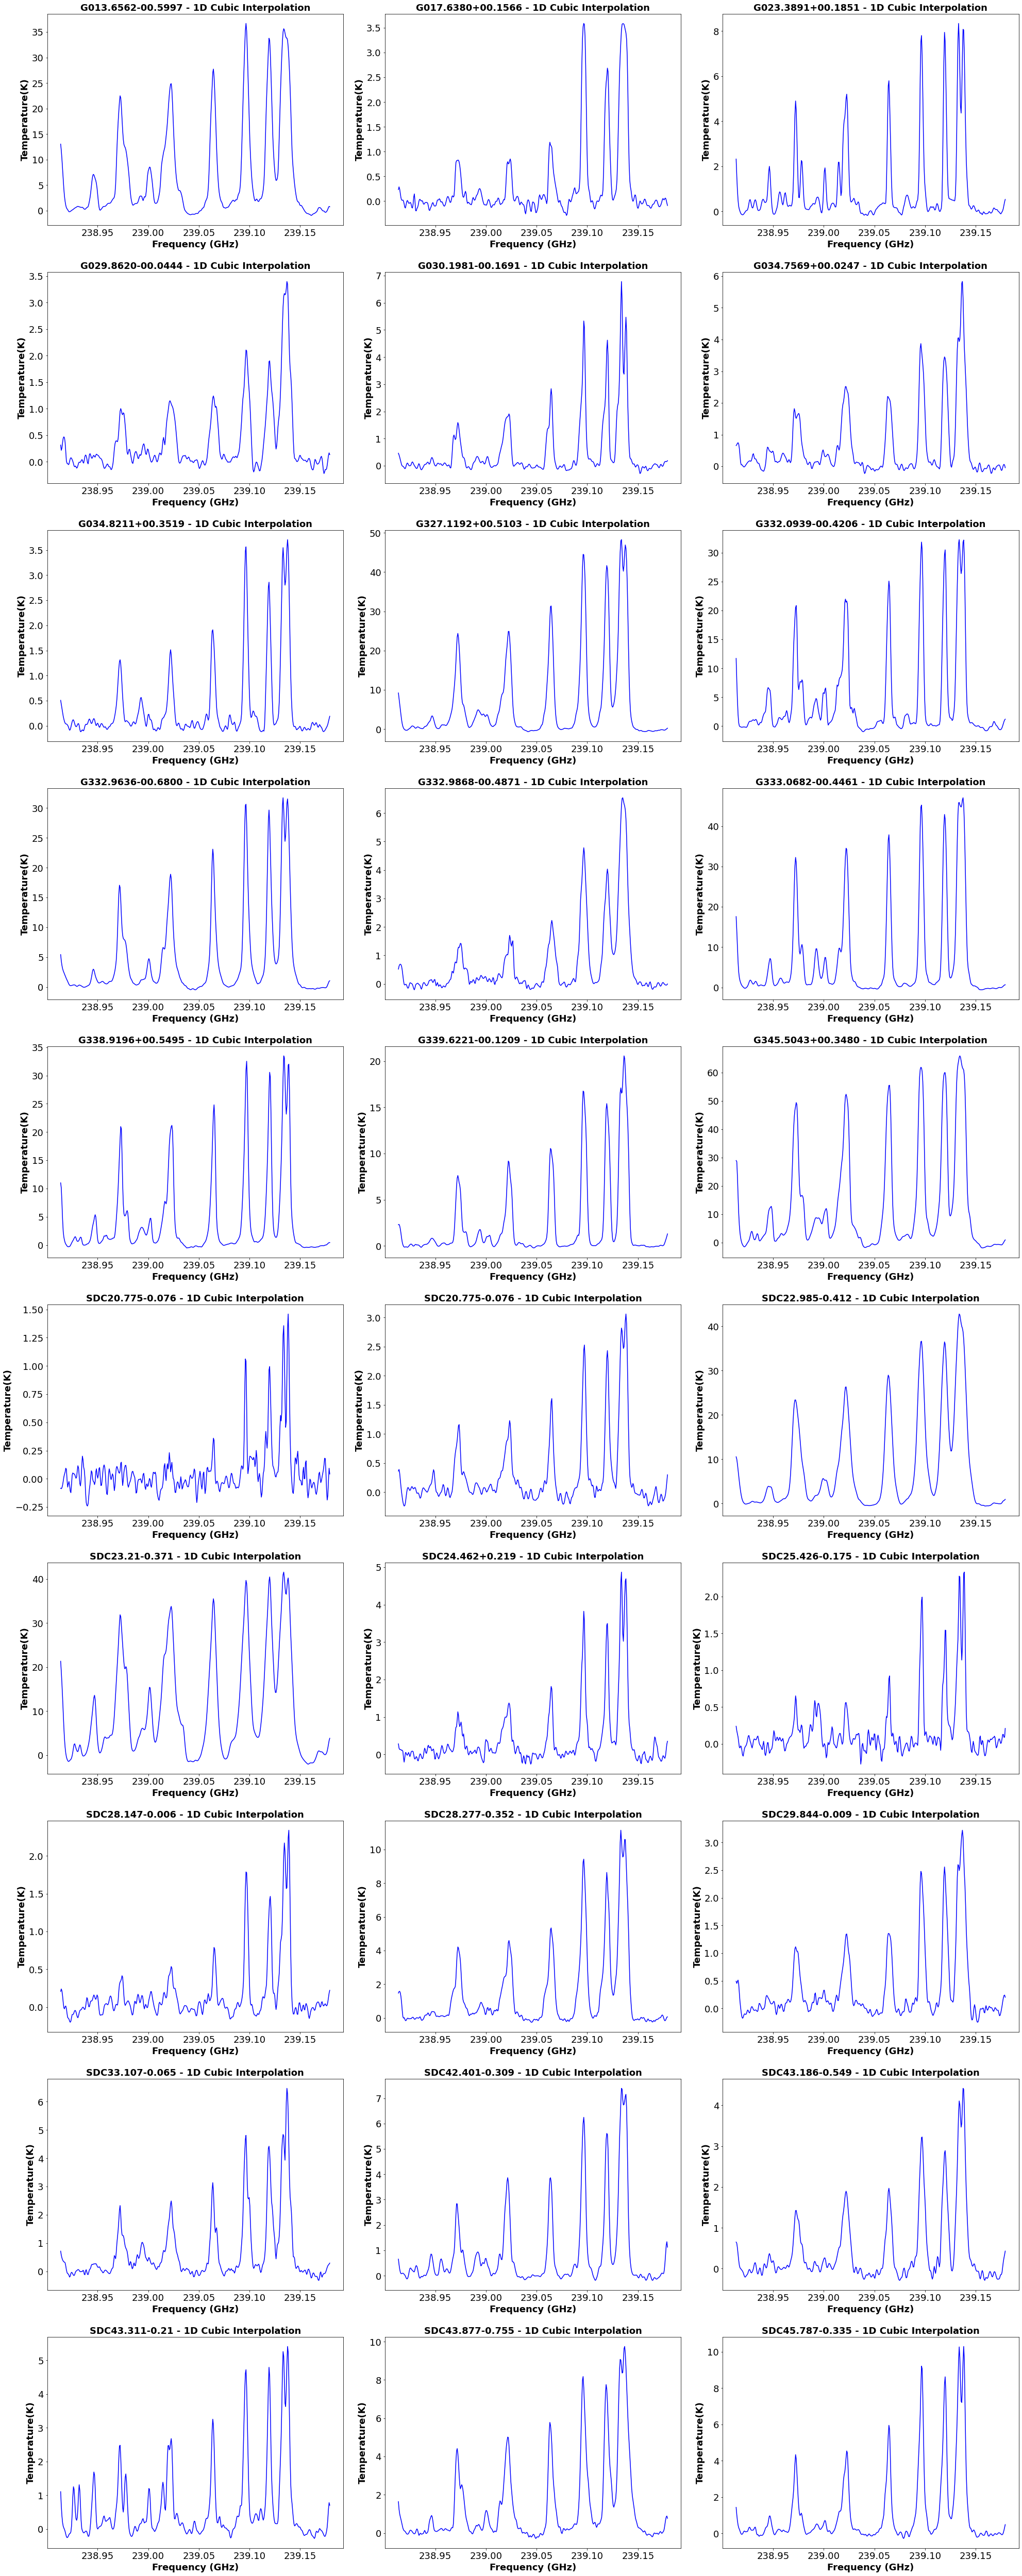

In [3]:
def interpolate_observational_data(CH3CN_DATA_PATH):
    ch3cn_files = sorted(glob.glob(CH3CN_DATA_PATH + '*.dat'), key=lambda x: int(re.search(r'\d+', x).group()))
    # drop the files in the unwanted_files list
    ch3cn_files = [file for file in ch3cn_files if os.path.basename(file) not in unwanted_file_list]

    fig, ax = plt.subplots(nrows=10, ncols=3, figsize=(28, 70))
    fig.tight_layout(pad=5, w_pad=5, h_pad=7)

    # read the dat for all the files in the directory
    for axn,file in zip(ax.flatten(), sorted(ch3cn_files)):
        df_ch3cn = pd.read_csv(file, delim_whitespace=True)
        df_ch3cn.drop(df_ch3cn.columns[-1], axis=1, inplace=True)
        df_ch3cn.columns = ['RestFreq(Hz)', 'T(K)']
        # convert the RestFreq(Hz) to GHz
        df_ch3cn['RestFreq(GHz)'] = df_ch3cn['RestFreq(Hz)'] / 1e9
        # get the start and end frequencies to be 238.91 and 239.18 GHz
        df_ch3cn = df_ch3cn[(df_ch3cn['RestFreq(GHz)'] >= df_ch3cn['RestFreq(GHz)'].min()) & (df_ch3cn['RestFreq(GHz)'] <= 239.18)]

        x = df_ch3cn['RestFreq(GHz)']
        y = df_ch3cn['T(K)']

        # new length of the data to match the number of features used in the model
        new_length = 422
        # new x values
        new_x = np.linspace(x.min(), x.max(), new_length)
        # new y values
        new_y = interpolate.interp1d(x, y, kind='cubic')(new_x)
        # print(f'{file} has {len(new_y)} rows')

        # plot the data
        axn.plot(new_x, new_y, color='blue')
        axn.set_xlabel('Frequency (GHz)', fontsize=18, fontweight='bold')
        axn.set_ylabel('Temperature(K)', fontsize=18, fontweight='bold')
        axn.tick_params(axis='both', which='major', labelsize=18)
        axn.set_title(file.split('/')[-1].split('_')[0] + ' - 1D Cubic Interpolation', fontsize=18, fontweight='bold')

interpolate_observational_data(CH3CN_DATA_PATH)
# plt.savefig(CH3CH_DATA_OUTPUT_PATH + 'ch3cn_spec_1D_interpolation.pdf', dpi=100)
    

In [4]:
# get model path and load the model
model_path = '../data/models/'

rf_model = joblib.load(os.path.join(model_path + 'rf_model.pkl'))
xgb_model = joblib.load(os.path.join(model_path + 'xgb_model.pkl'))
xgb_tuned_model = joblib.load(os.path.join(model_path, 'xgb_tuned_model.pkl'))

# test_model = joblib.load(os.path.join(model_path + 'test_xgb_tuned_model.pkl'))
# test_20k_model = joblib.load(os.path.join(model_path + 'test_20k_xgb_tuned_model.pkl'))


/Users/user/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


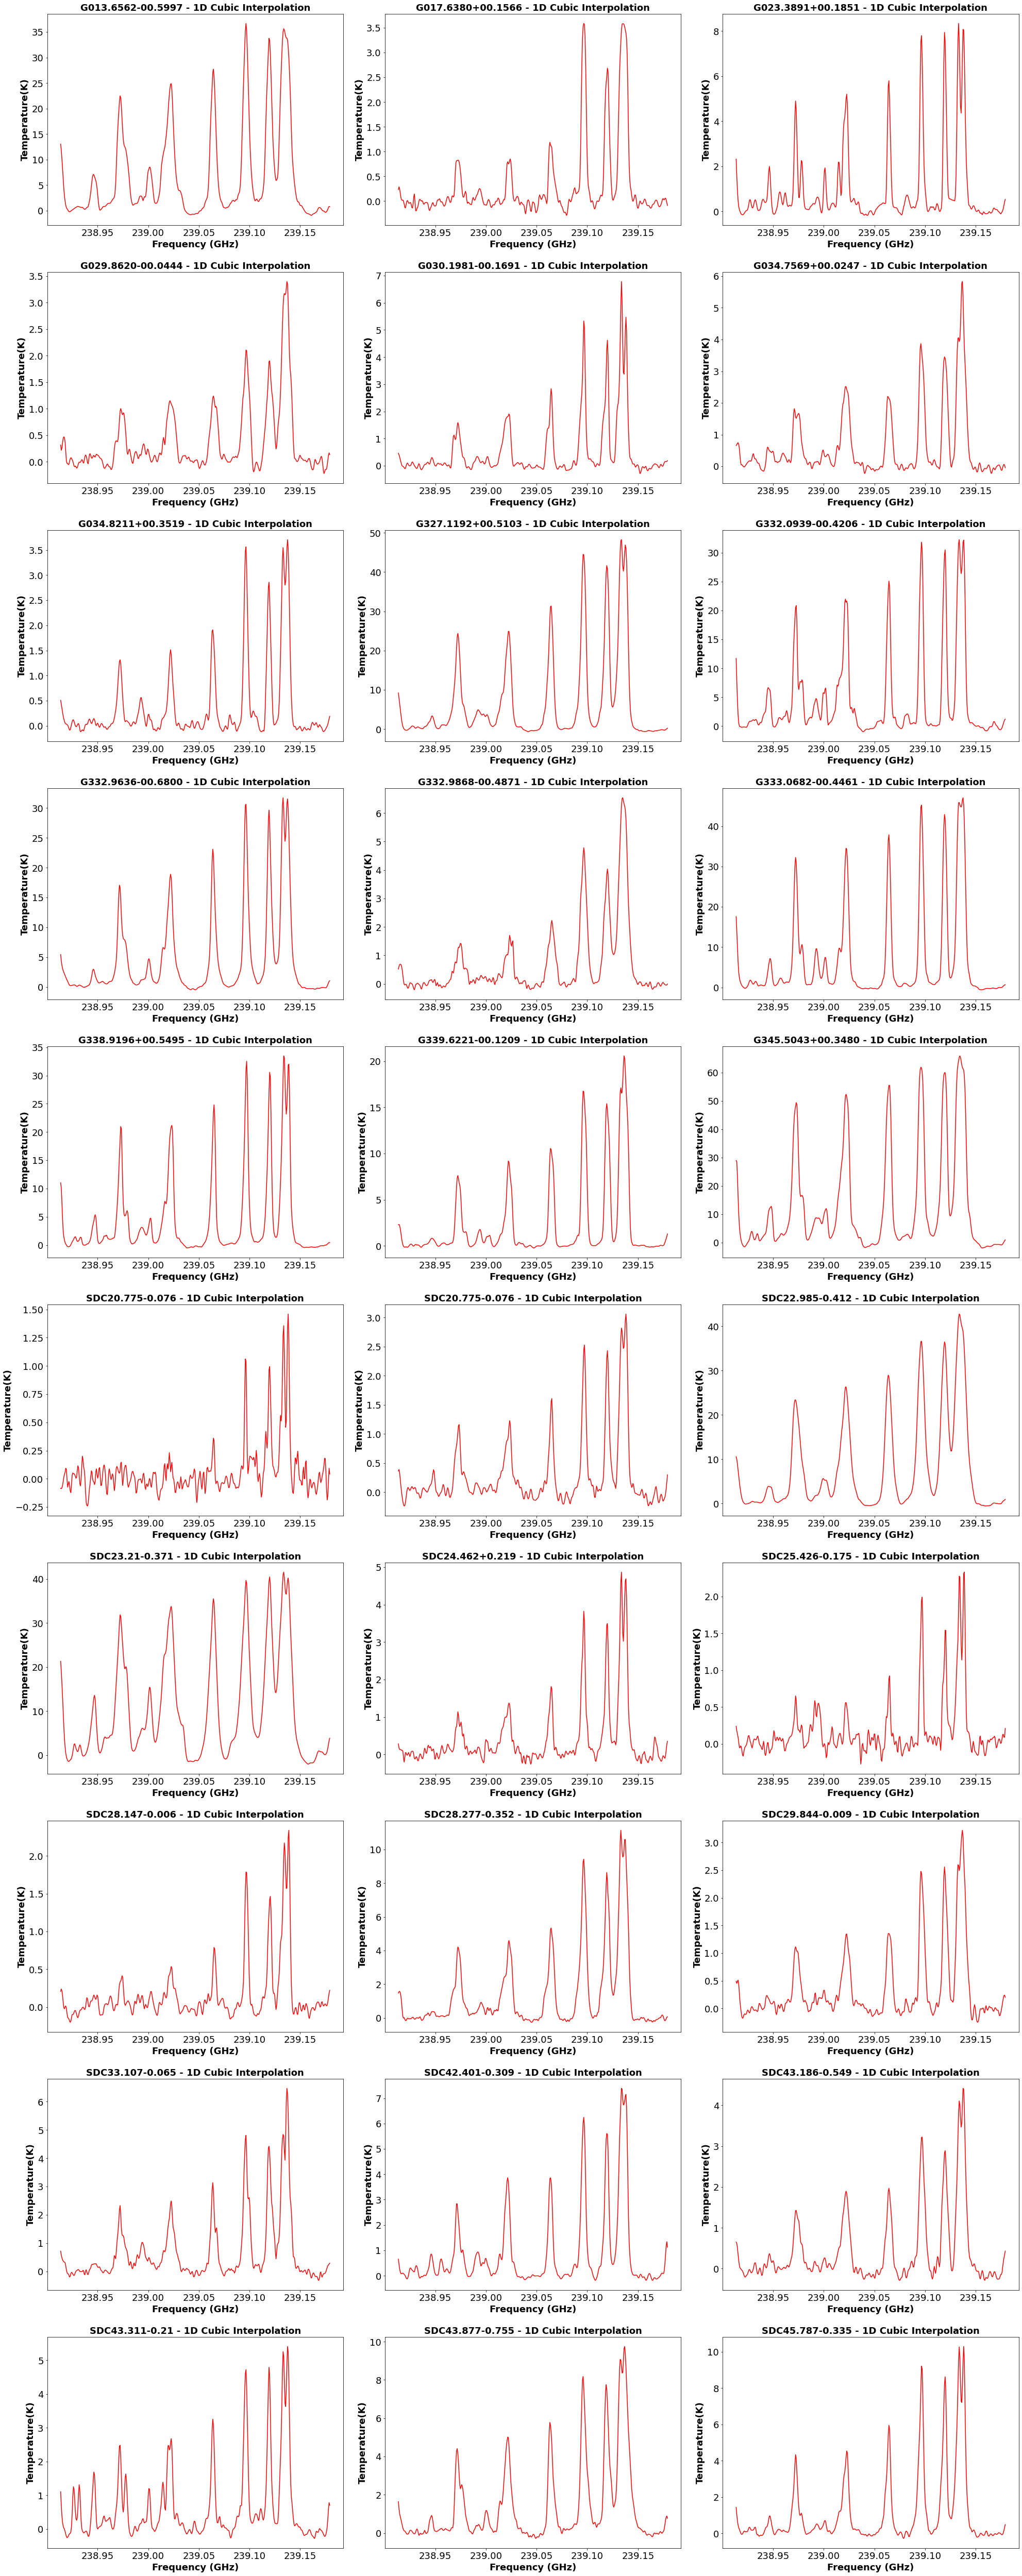

In [5]:
def predict_ch3cn_parameters(model, CH3CN_DATA_PATH):

    ch3cn_files = sorted(glob.glob(CH3CN_DATA_PATH + '*.dat'), key=lambda x: int(re.search(r'\d+', x).group()))
    # drop the files in the unwanted_files list
    ch3cn_files = [file for file in ch3cn_files if os.path.basename(file) not in unwanted_file_list]

    fig, ax = plt.subplots(nrows=10, ncols=3, figsize=(28, 70))
    fig.tight_layout(pad=5, w_pad=5, h_pad=7)

    # read the dat for all the files in the directory
    for axn,file in zip(ax.flatten(), sorted(ch3cn_files)):
        df_ch3cn = pd.read_csv(file, delim_whitespace=True)
        df_ch3cn.drop(df_ch3cn.columns[-1], axis=1, inplace=True)
        df_ch3cn.columns = ['RestFreq(Hz)', 'T(K)']
        # convert the RestFreq(Hz) to GHz
        df_ch3cn['RestFreq(GHz)'] = df_ch3cn['RestFreq(Hz)'] / 1e9
        # get the start and end frequencies to be 238.60 and 239.18 GHz
        df_ch3cn = df_ch3cn[(df_ch3cn['RestFreq(GHz)'] >= df_ch3cn['RestFreq(GHz)'].min()) & (df_ch3cn['RestFreq(GHz)'] <= 239.18)]

        x = df_ch3cn['RestFreq(GHz)']
        y = df_ch3cn['T(K)']


        # new length of the data
        new_length = 422
        # new x values
        new_x = np.linspace(x.min(), x.max(), new_length)
        # new y values
        new_y = interpolate.interp1d(x, y, kind='cubic')(new_x)

        # use the model to predict the parameters for the ch3cn model get the predicted parameters
        predicted_params = model.predict(new_y.reshape(1,-1))
        # save the predicted parameters to a dataframe
        df_predicted_parameters = pd.DataFrame(predicted_params, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'])
        df_predicted_parameters['ntot'] = np.array(10**df_predicted_parameters['ntot']) # convert the ntot to linear scale

         # get a dataframe with the predicted parameters + the file name without the .dat extension
        df_predicted_parameters['filename'] = os.path.basename(file).replace('.dat', '')

        # save the prerdicted parameters to a csv file  
        # df_predicted_parameters.to_csv(C3CHN_GENERATED_FILES_OUTPUT_PATH + filename, mode='a', header=False,  index=False)
        
        # plot the interpolated data 
        axn.plot(new_x, new_y, color='red')
        axn.set_xlabel('Frequency (GHz)', fontsize=18, fontweight='bold')
        axn.set_ylabel('Temperature(K)', fontsize=18, fontweight='bold')
        axn.tick_params(axis='both', which='major', labelsize=18)
        axn.set_title(file.split('/')[-1].split('_')[0] + ' - 1D Cubic Interpolation' , fontsize=18, fontweight='bold')
        
        
        params = df_predicted_parameters.iloc[0]
        params = '\nFWHM = {:.2f} km/s \nntot = {:.3g} $cm^-2$ \nsize = {:.2f} arcsec \nTex = {:.2f} K \nvslr = {:.2f} km/s'.format(params['fwhm'], params['ntot'], params['size'], params['tex'], params['vlsr'])
        # add a text box with the predicted parameters for each subplot corresponding to each file
        # plt.text(0.05, 0.6, params, transform=axn.transAxes, color='black', bbox = dict(boxstyle='round', facecolor = 'red', alpha = 0.4),  fontsize=12)    


predict_ch3cn_parameters(xgb_tuned_model, CH3CN_DATA_PATH)
# plt.savefig(CH3CH_DATA_OUTPUT_PATH + 'xgb_tuned_ch3cn_predicted_params.pdf', dpi=100)
    

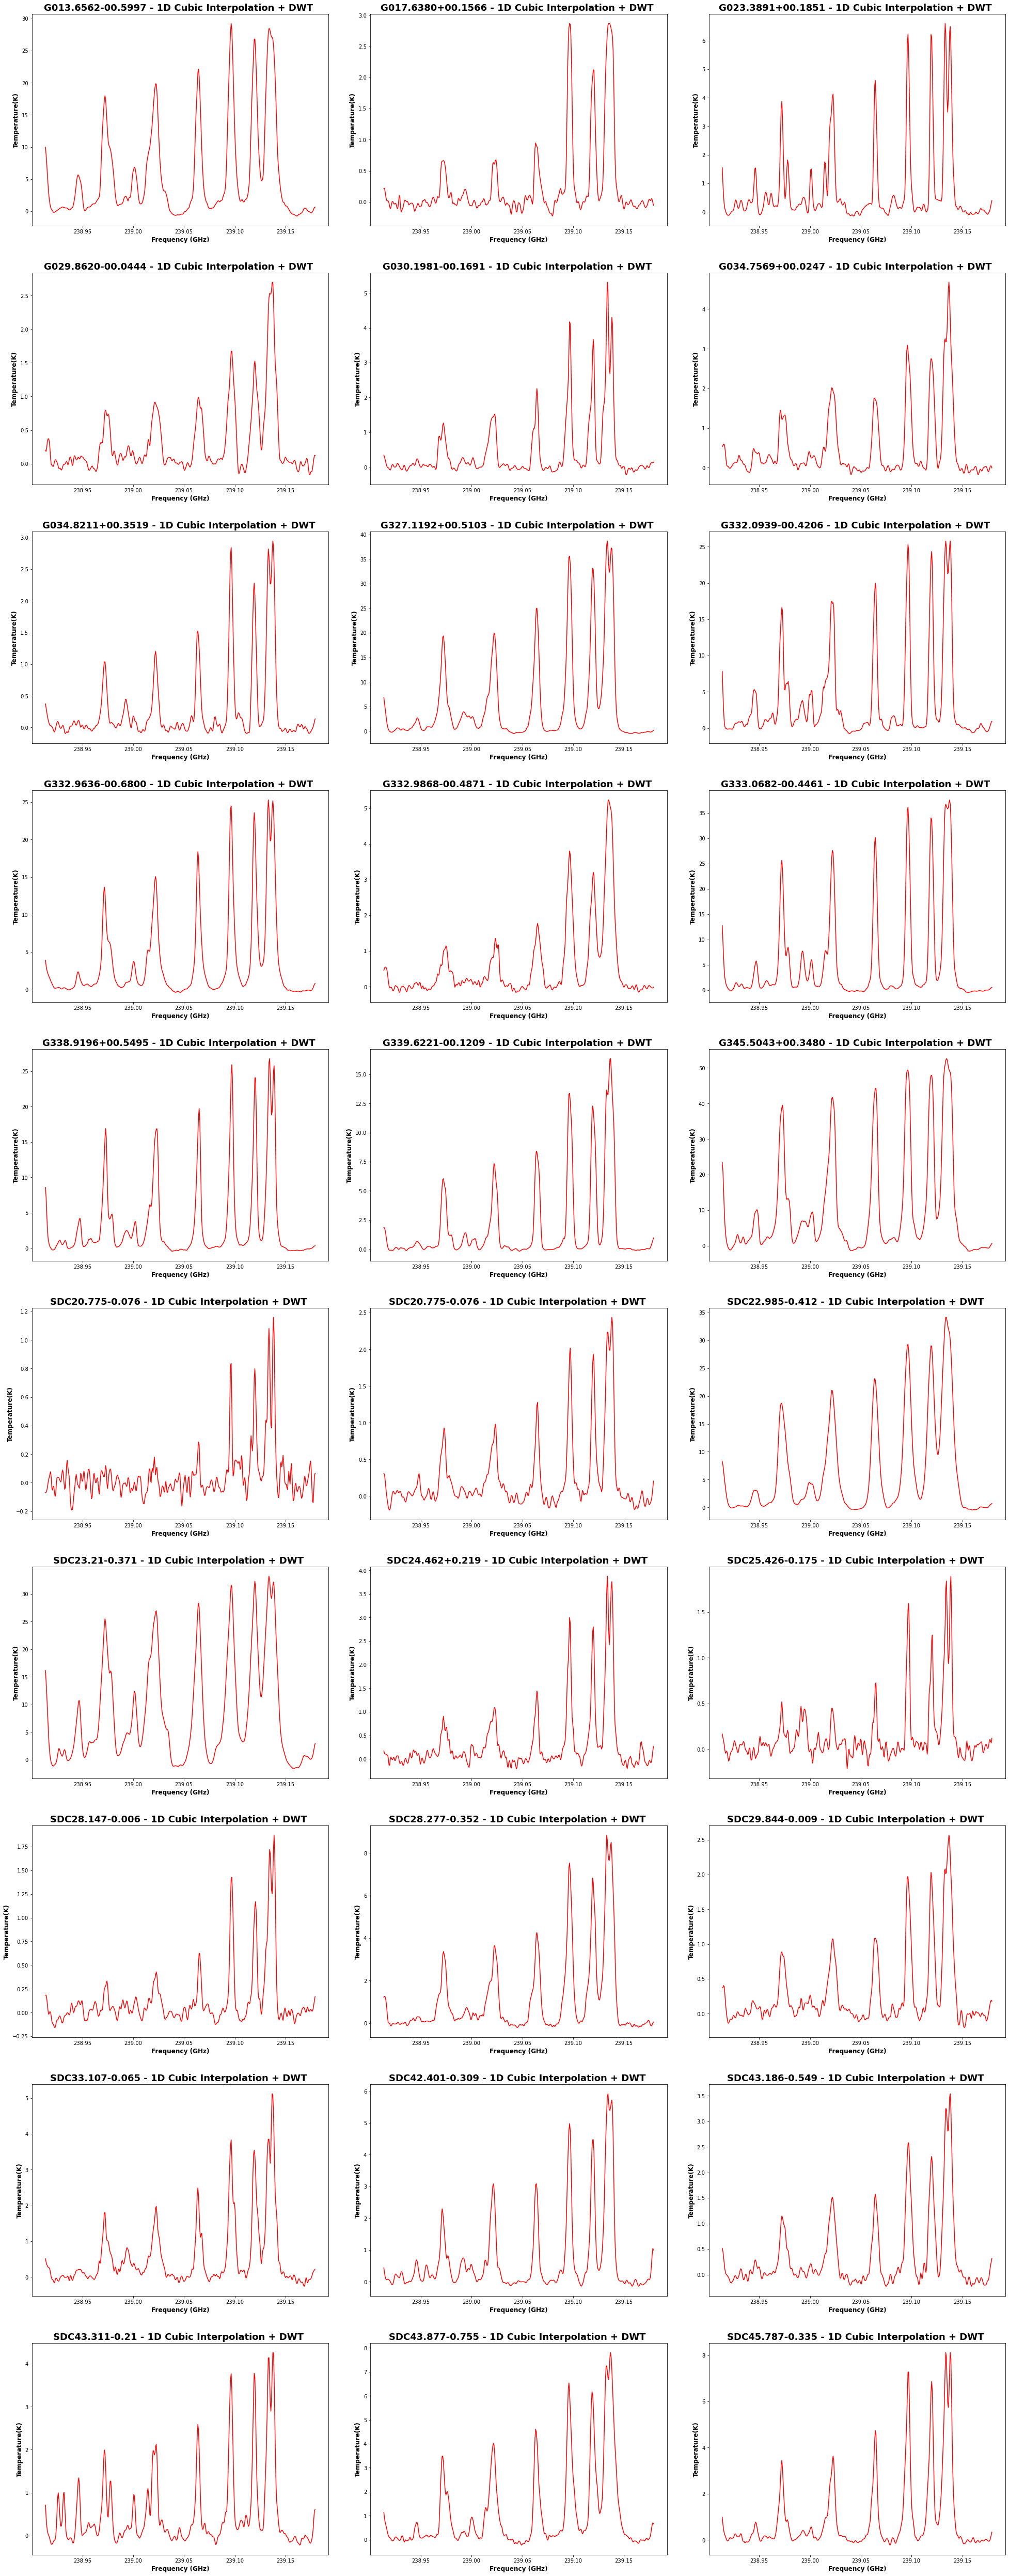

In [8]:
def dwt_observational_data(CH3CN_DATA_PATH, model, filename):

    ch3cn_files = sorted(glob.glob(CH3CN_DATA_PATH + '*.dat'), key=lambda x: int(re.search(r'\d+', x).group()))
    # drop the files in the unwanted_files list
    ch3cn_files = [file for file in ch3cn_files if os.path.basename(file) not in unwanted_file_list]

    fig, ax = plt.subplots(nrows=10, ncols=3, figsize=(28, 70))
    fig.tight_layout(pad=5, w_pad=5, h_pad=7)

    # read the dat for all the files in the directory
    for axn,file in zip(ax.flatten(), sorted(ch3cn_files)):
        df_ch3cn = pd.read_csv(file, delim_whitespace=True)
        df_ch3cn.drop(df_ch3cn.columns[-1], axis=1, inplace=True)
        df_ch3cn.columns = ['RestFreq(Hz)', 'T(K)']
        # convert the RestFreq(Hz) to GHz
        df_ch3cn['RestFreq(GHz)'] = df_ch3cn['RestFreq(Hz)'] / 1e9
        # get the start and end frequencies to be 238.60 and 239.18 GHz
        df_ch3cn = df_ch3cn[(df_ch3cn['RestFreq(GHz)'] >= 238.91) & (df_ch3cn['RestFreq(GHz)'] <= 239.18)]

        x = df_ch3cn['RestFreq(GHz)']
        y = df_ch3cn['T(K)']
        
        xx_new_lenghth = 422
        xx = x.values
        # yy = y.values
        xx_new = np.linspace(xx.min(), xx.max(), xx_new_lenghth)
        # yy_new = interpolate.interp1d(xx, yy, kind='cubic')(xx_new)

        # new length of the data
        new_length = 27000
        # new x values
        new_x = np.linspace(x.min(), x.max(), new_length)
        # new y values
        new_y = interpolate.interp1d(x, y, kind='cubic')(new_x)

        detail_coeffs = np.zeros((len(new_y), 422))
        approx_coeffs = np.zeros((len(new_y), 422))
        
        # denoise the data using the wavelet transform to get the wavelet coefficients
        coeffs = pywt.wavedec(new_y, 'db1', mode='per',  level=6)
        coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
        # get the detail coefficients
        detail_coeffs = coeff_arr[coeff_slices[1]['d']]
        # get the approximated coefficients
        approx_coeffs = coeffs[0]


        # print(len(approx_coeffs))

        # use the model to predict the parameters for the ch3cn model and get the predicted parameters
        predicted_parameters = model.predict(detail_coeffs.reshape(1,-1))
        # save the predicted parameters to a dataframe
        df_predicted_parameters = pd.DataFrame(predicted_parameters, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'])
        df_predicted_parameters['ntot'] = np.array(10**df_predicted_parameters['ntot']) # convert the ntot to linear scale
        # get a dataframe with the predicted parameters + the file name without the .dat extension
        df_predicted_parameters['filename'] = os.path.basename(file).replace('.dat', '')

        # save the predicted parameters to a csv file by writing to the output directory and overwriting the file if it already exists
        df_predicted_parameters.to_csv(C3CHN_GENERATED_FILES_OUTPUT_PATH + filename, mode='a', header=False,  index=False)

        # plot the interpolated data 
        axn.plot(xx_new, approx_coeffs/10, color='red')
        axn.set_xlabel('Frequency (GHz)', fontsize=12, fontweight='bold')
        axn.set_ylabel('Temperature(K)', fontsize=12, fontweight='bold')
        axn.set_title(file.split('/')[-1].split('_')[0] + ' - 1D Cubic Interpolation + DWT ', fontsize=18, fontweight='bold')
        
        
        params = df_predicted_parameters.iloc[0]
        params = '\nFWHM = {:.2f} km/s \nntot = {:.3g} $cm^-2$ \nsize = {:.2f} arcsec \nTex = {:.2f} K \nvslr = {:.2f} km/s'.format(params['fwhm'], params['ntot'], params['size'], params['tex'], params['vlsr'])
        # plt.text(0.05, 0.6, params, transform=axn.transAxes, color='black', bbox = dict(boxstyle='round', facecolor = 'red', alpha = 0.4),  fontsize=8)

dwt_observational_data(CH3CN_DATA_PATH, xgb_tuned_model, 'xgb_tuned_interpolation_dwt_pred.csv')
# plt.savefig(CH3CH_DATA_OUTPUT_PATH + 'xgb_tuned_ch3cn_interpolation_dwt.pdf', dpi=100)

#### Signal Denoising with DWT

The denosing algorithm is based in the following steps:

1. Apply the dwt to the signal.
2. Compute the threshold corresponding to the chosen level, see [phd thesis](https://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf)
3. Only keep coefficients with a value higher than the threshold
3. Apply the inverse dwt to retrieve the signal, i.e., the reconstructed signal.

Code (some parts) implementation from: [kaggle](https://www.kaggle.com/code/jpandeinge/denoising-with-direct-wavelet-transform)


The Mean Absolute Deviation (MAD) is a measure of dispersion. It is given by:

    MAD = 1\N * sum(|x_i - x_mean|)

where `x_i` is the i-th element of the signal, and `x_mean` is the mean of the signal.

In [9]:
def madev(coeff_data, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(coeff_data - np.mean(coeff_data, axis)), axis)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(

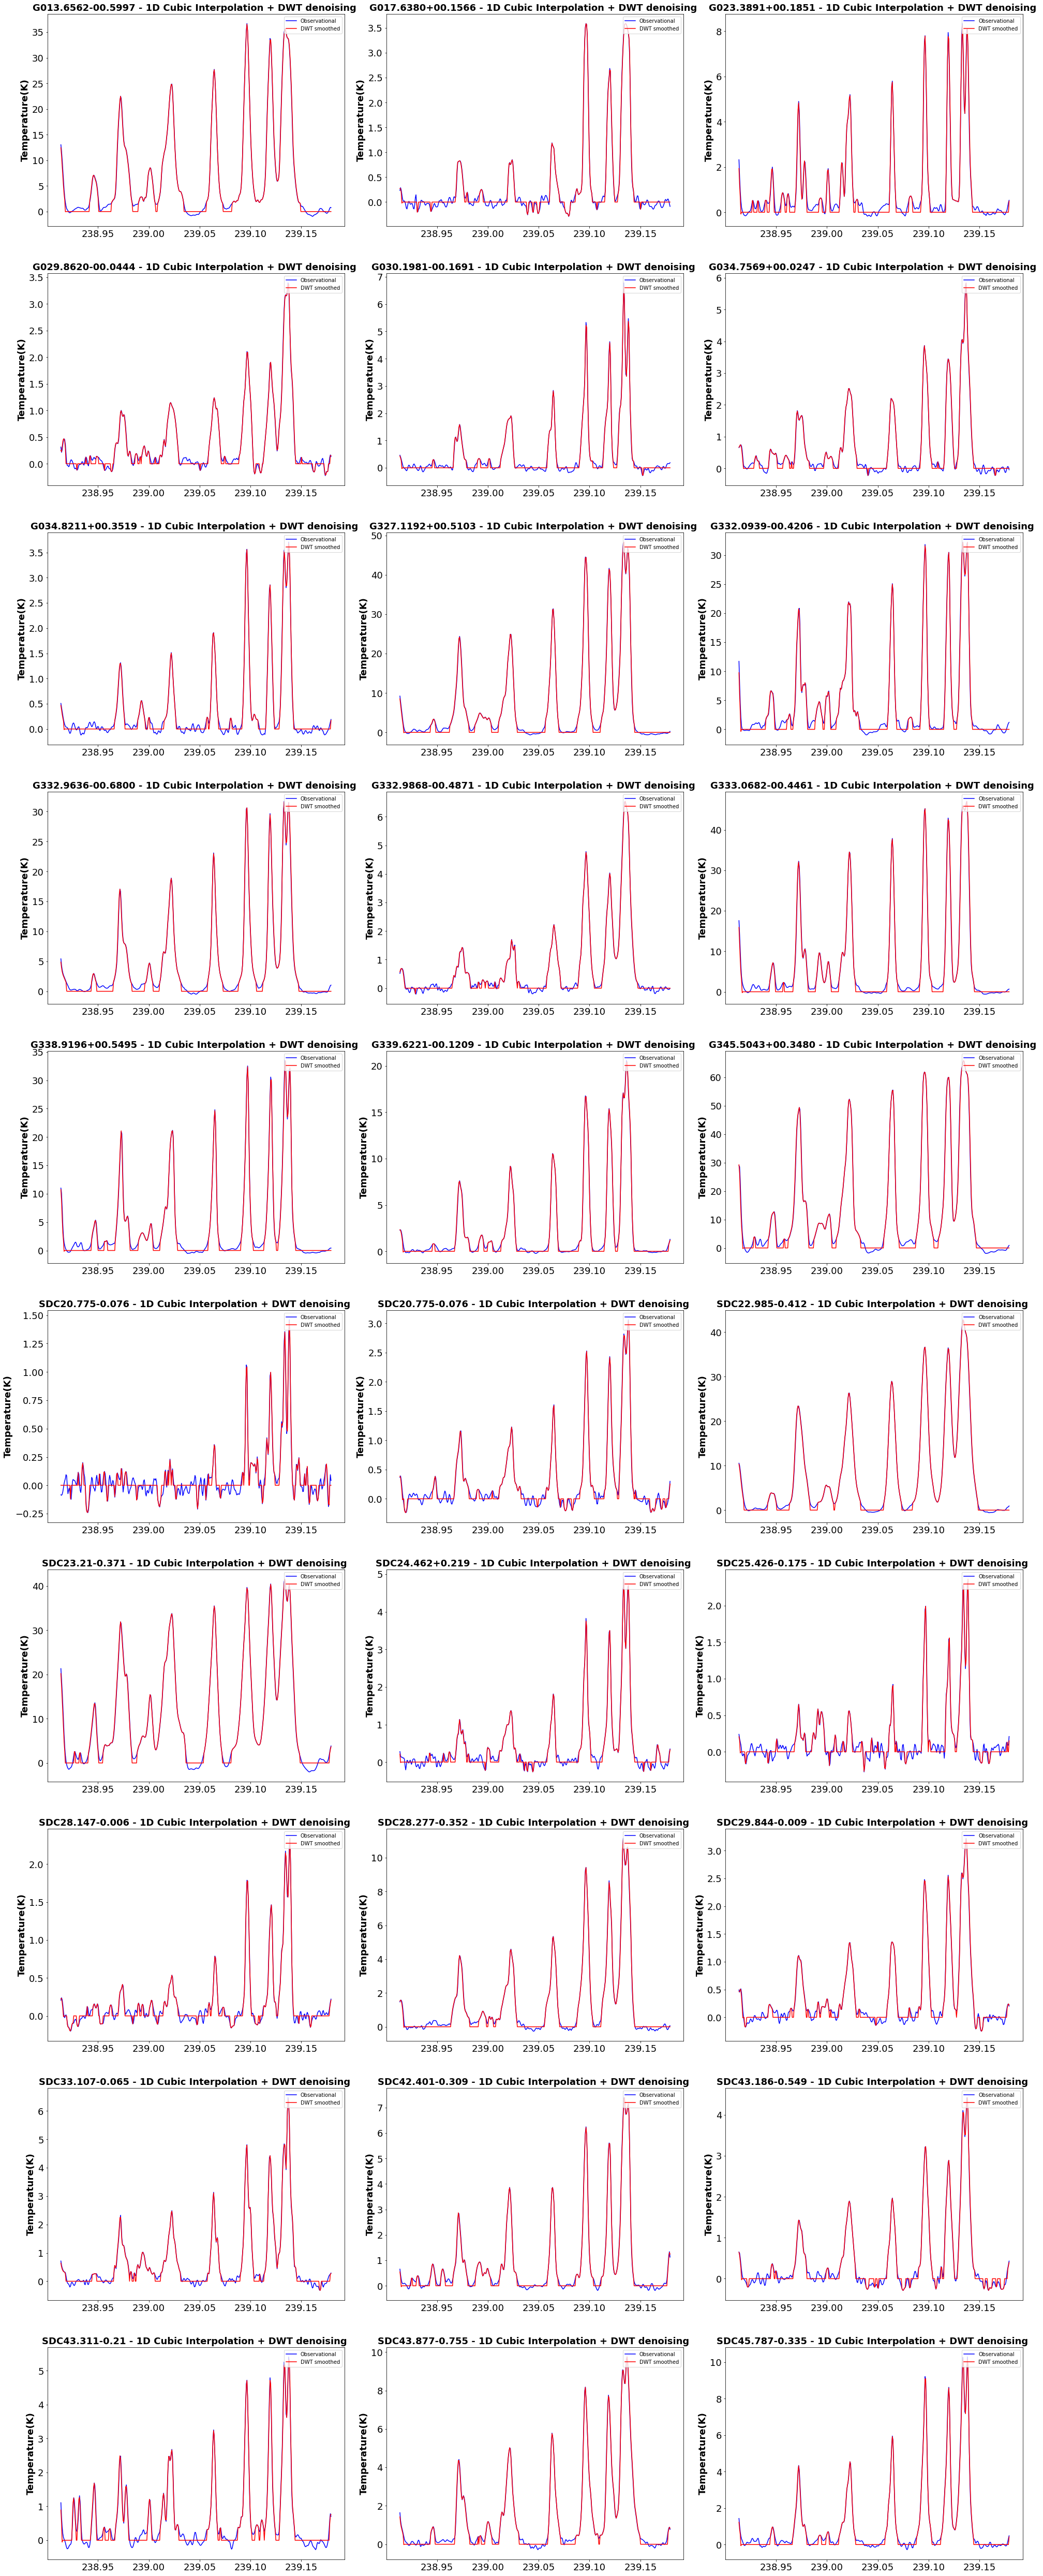

In [12]:
def denoise_observational_data(CH3CN_DATA_PATH, model, filename):

    ch3cn_files = sorted(glob.glob(CH3CN_DATA_PATH + '*.dat'), key=lambda x: int(re.search(r'\d+', x).group()))
    # drop the files in the unwanted_files list
    ch3cn_files = [file for file in ch3cn_files if os.path.basename(file) not in unwanted_file_list]

    fig, ax = plt.subplots(nrows=10, ncols=3, figsize=(28, 70))
    fig.tight_layout(pad=5, w_pad=5, h_pad=7)

    # get the files from 8 to 16


    # read the dat for all the files in the directory
    for axn,file in zip(ax.flatten(), sorted(ch3cn_files)):
        df_ch3cn = pd.read_csv(file, delim_whitespace=True)
        df_ch3cn.drop(df_ch3cn.columns[-1], axis=1, inplace=True)
        df_ch3cn.columns = ['RestFreq(Hz)', 'T(K)']
        # convert the RestFreq(Hz) to GHz
        df_ch3cn['RestFreq(GHz)'] = df_ch3cn['RestFreq(Hz)'] / 1e9
        # get the start and end frequencies to be 238.60 and 239.18 GHz
        df_ch3cn = df_ch3cn[(df_ch3cn['RestFreq(GHz)'] >=  238.91) & (df_ch3cn['RestFreq(GHz)'] <= 239.18)]
        # row_one_vals = pd.DataFrame({"RestFreq(GHz)": 238.60, "T(K)": 0.0}, index=[0])
        # df_ch3cn = pd.concat([df_ch3cn.iloc[:0], row_one_vals, df_ch3cn.iloc[0:]]).reset_index(drop=True)


        x = df_ch3cn['RestFreq(GHz)']
        y = df_ch3cn['T(K)']
        # print(x)


        # new length of the data to match the length of the synthetic data
        new_length = 27000
        # new x values
        new_x = np.linspace(x.min(), x.max(), new_length)
        # new y values
        new_y = interpolate.interp1d(x, y, kind='cubic')(new_x)

        detail_coeffs = np.zeros((len(new_y), 422))
        approx_coeffs = np.zeros((len(new_y), 422))
    
        # denoise the data using the wavelet transform and get the wavelet coefficients
        level = 6
        coeffs = pywt.wavedec(new_y, 'db1', mode='per',  level=level)
        # calculate sigma of the coefficients
        sigma = (1/0.6745) * madev(coeffs[-level])
        # calculate the threshold
        threshold_value = sigma * np.sqrt(2*np.log(len(new_y)))
        coeffs[1:] = (pywt.threshold(i, value=threshold_value, mode="hard" ) for i in coeffs[1:]) # apply the threshold to the detail coefficients
        coeffs[0] = pywt.threshold(coeffs[0], value=threshold_value, mode="hard") # apply the threshold to the approximated coefficients
        # assign the denoised approximation coefficients to a new variable
        coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
        reconstructed_signal = pywt.waverec(coeffs, 'db1', mode="per")

        # get the detail coefficients
        detail_coeffs = coeff_arr[coeff_slices[1]['d']]
        # get the approximated coefficients
        approx_coeffs = coeffs[0]

        # approx_coeffs = StandardScaler().fit_transform(approx_coeffs.reshape(-1, 1))

        

        # interpolate the reconstructed signal to have 454 points
        xx_new_length = 422
        xx = x.values
        xx_new = np.linspace(xx.min(), xx.max(), xx_new_length)
        # interpolate the original signal to have 422 points
        new_yy = interpolate.interp1d(x, y, kind='cubic')(xx_new)
        # interpolate the denoised data to have 422 points
        yy_new = interpolate.interp1d(new_x, reconstructed_signal, kind='cubic')(xx_new)

    
        
        # use the model to predict the parameters for the ch3cn model and get the predicted parameters
        # predicted_parameters = model.predict(np.array(approx_coeffs).reshape(1,-1))
        # use the pytorch model to predict the parameters for the ch3cn model and get the predicted parameters
        predicted_parameters = model.predict(np.array(approx_coeffs).reshape(1,-1))
        # save the predicted parameters to a dataframe
        df_predicted_parameters = pd.DataFrame(predicted_parameters, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'])
        df_predicted_parameters['ntot'] = np.array(10**df_predicted_parameters['ntot']) # convert the ntot to linear scale
        # get a dataframe with the predicted parameters + the file name without the .dat extension
        df_predicted_parameters['filename'] = os.path.basename(file).replace('.dat', '')
    
        # df_predicted_parameters['filename'] = file.split('/')[-1]

        # save the predicted parameters to a csv file by writing to the output directory and overwriting the file if it already exists
        df_predicted_parameters.to_csv(C3CHN_GENERATED_FILES_OUTPUT_PATH + filename, mode='a', header=False,  index=False)

        # plot the interpolated data 
        axn.plot(xx_new, new_yy, color='blue', label='Observational')
        axn.plot(xx_new, yy_new, color='red', label='DWT smoothed')
        axn.set_ylabel('Temperature(K)', fontsize=18, fontweight='bold')
        axn.tick_params(axis='both', which='major', labelsize=18)
        axn.set_title(file.split('/')[-1].split('_')[0] + ' - 1D Cubic Interpolation + DWT denoising ', fontsize=18, fontweight='bold')
        axn.legend(loc='upper right')
        
        params = df_predicted_parameters.iloc[0]
        params = '\nFWHM = {:.2f} km/s \nntot = {:.3g} $cm^-2$ \nsize = {:.2f} arcsec \nTex = {:.2f} K \nvslr = {:.2f} km/s'.format(params['fwhm'], params['ntot'], params['size'], params['tex'], params['vlsr'])
        # plt.text(0.05, 0.6, params, transform=axn.transAxes, color='black', bbox = dict(boxstyle='round', facecolor = 'red', alpha = 0.4),  fontsize=12)

denoise_observational_data(CH3CN_DATA_PATH, rf_model, 'rf_ch3cn_hard_thresholding_dwt_pred_1.csv')
# plt.savefig(CH3CH_DATA_OUTPUT_PATH + 'rf_ch3cn_interpolation_dwt_denosing.pdf', dpi=100)

### Reconstruction of Observational Data From Predictions

In [19]:
RF_RECONSTRUCTED_PATH = '../data/observational/ch3cn_reconstructed/rf/'
XGB_RECONSTRUCTED_PATH = '../data/observational/ch3cn_reconstructed/xgb/'
XGB_TUNED_RECONSTRUCTED_PATH = '../data/observational/ch3cn_reconstructed/xgb_tuned/'

# FITTED_RESULTS_RECONSTRUCTED_PATH = '../data/observational/ch3cn_reconstructed/nn/'

# TEST_RECONSTRUCTED_PATH = '../data/observational/ch3cn_reconstructed/test/'

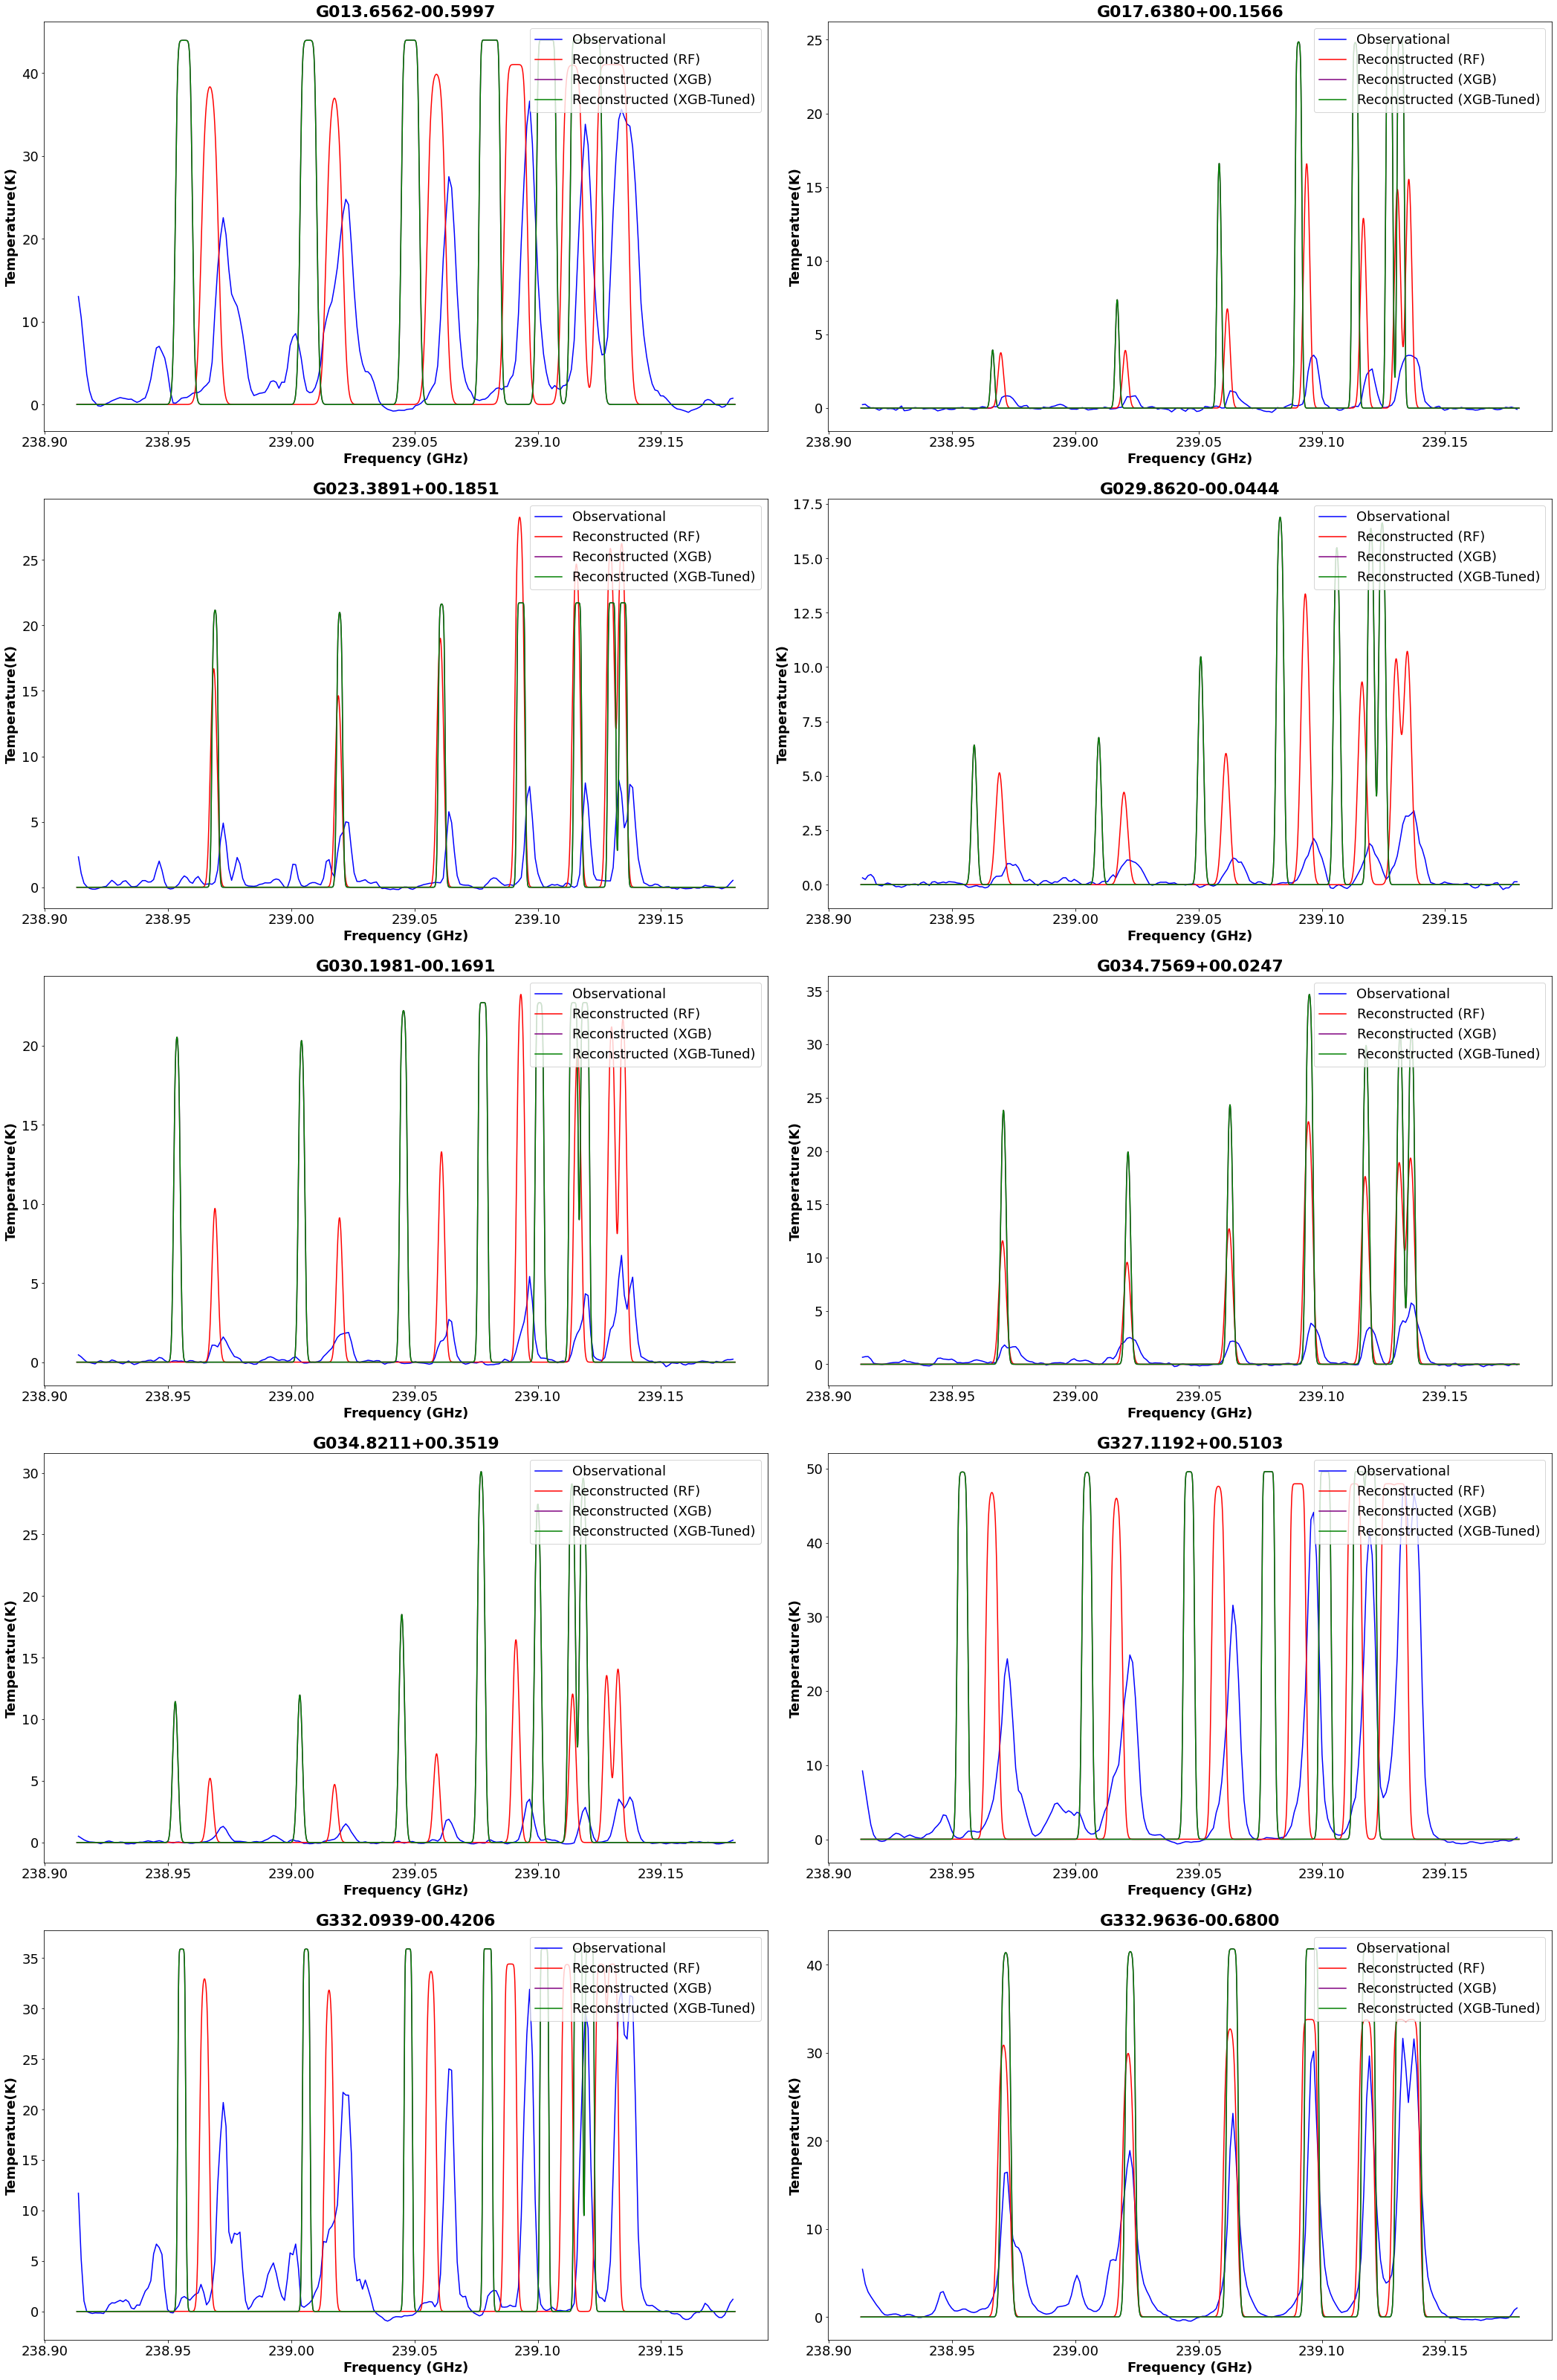

In [54]:
def plot_observational_reconstructed_data(CH3CN_DATA_PATH, RF_RECONSTRUCTED_PATH, XGB_RECONSTRUCTED_PATH, XGB_TUNED_RECONSTRUCTED_PATH):
    '''
    Plot the observatinal data and reconstructed data on the same plots and compare 
    '''
    observational_files  = sorted(glob.glob(CH3CN_DATA_PATH + '*.dat'), key=lambda x: int(re.search(r'\d+', x).group()))
    observational_files = [file for file in observational_files if os.path.basename(file) not in unwanted_file_list]

    # # get the files 10 files
    # obs10 = observational_files[:10]
    # # get the files from 10 t0 20 withouth the ones in obs10
    # obs20 = [file for file in observational_files[10:20] if file not in obs10]
    # # get the files from 20 to 30 without the ones in obs10 and obs20
    # obs30 = [file for file in observational_files[20:30] if file not in obs10 and file not in obs20]




    rf_reconstructed_files = sorted(glob.glob(RF_RECONSTRUCTED_PATH + '*.txt'), key=lambda x: int(re.search(r'\d+', x).group()))
    xgb_reconstructed_files = sorted(glob.glob(XGB_RECONSTRUCTED_PATH + '*.txt'), key=lambda x: int(re.search(r'\d+', x).group()))
    xgb_tuned_reconstructed_files = sorted(glob.glob(XGB_TUNED_RECONSTRUCTED_PATH + '*.txt'), key=lambda x: int(re.search(r'\d+', x).group()))

    # results_reconstructed_files = sorted(glob.glob(FITTED_RESULTS_RECONSTRUCTED_PATH + '*.txt'), key=lambda x: int(re.search(r'\d+', x).group()))


    # rf_10 = rf_reconstructed_files[:10]
    # rf_20 = [file for file in rf_reconstructed_files[10:20] if file not in rf_10]
    # rf_30 = [file for file in rf_reconstructed_files[20:30] if file not in rf_10 and file not in rf_20]

    # xgb_10 = xgb_reconstructed_files[:10]
    # xgb_20 = [file for file in xgb_reconstructed_files[10:20] if file not in xgb_10]
    # xgb_30 = [file for file in xgb_reconstructed_files[20:30] if file not in xgb_10 and file not in xgb_20]

    # xgb_tuned_10 = xgb_tuned_reconstructed_files[:10]
    # xgb_tuned_20 = [file for file in xgb_tuned_reconstructed_files[10:20] if file not in xgb_tuned_10]
    # xgb_tuned_30 = [file for file in xgb_tuned_reconstructed_files[20:30] if file not in xgb_tuned_10 and file not in xgb_tuned_20]


    # test_reconstructed_files = sorted(glob.glob(TEST_RECONSTRUCTED_PATH + '*.txt'), key=lambda x: int(re.search(r'\d+', x).group()))
    # reconstructed_files = [file for file in reconstructed_files if os.path.basename(file) not in unwanted_file_list]
    fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(30, 45))
    fig.tight_layout(pad=5, w_pad=5, h_pad=7)

    for axn, obs_file,rf_recon_file, xgb_recon_file, xgb_tuned_recon_file  in zip(ax.flatten(), sorted(observational_files), sorted(rf_reconstructed_files), sorted(xgb_reconstructed_files), sorted(xgb_reconstructed_files)):
        observational_df = pd.read_csv(obs_file, delim_whitespace=True)
        observational_df.drop(observational_df.columns[-1], axis=1, inplace=True)
        observational_df.columns = ['RestFreq(Hz)', 'T(K)']
        # convert the RestFreq(Hz) to GHz
        observational_df['RestFreq(GHz)'] = observational_df['RestFreq(Hz)'] / 1e9
        # get the start and end frequencies to be 238.60 and 239.18 GHz
        observational_df = observational_df[(observational_df['RestFreq(GHz)'] >= 238.91) & (observational_df['RestFreq(GHz)'] <= 239.18)]

    
        # set row one of the dataframe to be equal to 238.60 GHz and 0.00 for the temperature
        # row_one_vals = pd.DataFrame({"RestFreq(Hz)": 2.386e+11, "RestFreq(GHz)": 238.60, "T(K)": 0.0}, index=[0])
        # observational_df2 = pd.concat([observational_df.iloc[:0], row_one_vals, observational_df.iloc[0:]]).reset_index(drop=True)
        
    
        x_obs = observational_df['RestFreq(GHz)']
        y_obs = observational_df['T(K)']


    
    
        # # new length of the data to match the length of the synthetic data
        # new_obs_length = 58000
        # # new x values
        # new_obs_x = np.linspace(x_obs.min(), x_obs.max(), new_obs_length)
        # # interpolate the original signal to have 454 points
        # new_obs_y = interpolate.interp1d(x_obs, y_obs, kind='cubic')(new_obs_x)  

        # # get the reconstructed data
        rf_reconstructed_df = pd.read_csv(rf_recon_file, delim_whitespace=True) 
        xgb_reconstructed_df = pd.read_csv(xgb_recon_file, delim_whitespace=True) 
        xgb_tuned_reconstructed_df = pd.read_csv(xgb_tuned_recon_file, delim_whitespace=True) 

        # results_reconstructed_df = pd.read_csv(results_file, delim_whitespace=True) 

        # test_reconstructed_df = pd.read_csv(test_recon_file, delim_whitespace=True)
        # reconstructed_df = reconstructed_df[(reconstructed_df['RestFreq(GHz)'] > 238.91) & (reconstructed_df['RestFreq(GHz)'] < 239.18)]
        # print('Min RestFreq(GHz) = ', reconstructed_df['RestFreq(GHz)'].min(), 'Max RestFreq(GHz) = ', reconstructed_df['RestFreq(GHz)'].max())

        rf_x_recon = rf_reconstructed_df['RestFreq(GHz)']
        rf_y_recon = rf_reconstructed_df['T(K)'] 

        xgb_x_recon = xgb_reconstructed_df['RestFreq(GHz)']
        xgb_y_recon = xgb_reconstructed_df['T(K)'] 


        xgb_tuned_x_recon = xgb_tuned_reconstructed_df['RestFreq(GHz)']
        xgb_tuned_y_recon = xgb_tuned_reconstructed_df['T(K)'] 


        # results_x_recon = results_reconstructed_df['RestFreq(GHz)']
        # results_y_recon = results_reconstructed_df['T(K)']

        # test_x_recon = test_reconstructed_df['RestFreq(GHz)']
        # test_y_recon = test_reconstructed_df['T(K)']


        # plot the observational and reconstructed data
        axn.plot(x_obs, y_obs, color='blue', label='Observational')
        axn.plot(rf_x_recon, rf_y_recon, color='red', label='Reconstructed (RF)')
        axn.plot(xgb_x_recon, xgb_y_recon, color='purple', label='Reconstructed (XGB)')
        axn.plot(xgb_tuned_x_recon, xgb_tuned_y_recon, color='green', label='Reconstructed (XGB-Tuned)')
        # axn.plot(results_x_recon, results_y_recon, color='purple', label='NN Reconstructed data')

        # axn.plot(test_x_recon, test_y_recon, color='orange', label='Test Reconstructed data')
        axn.set_xlabel('Frequency (GHz)', fontsize=18, fontweight='bold')
        axn.set_ylabel('Temperature(K)', fontsize=18, fontweight='bold')
        axn.tick_params(axis='both', which='major', labelsize=18)
        axn.set_title(os.path.basename(obs_file).split('_')[0], fontsize=22, fontweight='bold')
        axn.legend(loc='upper right', fontsize=18)


plot_observational_reconstructed_data(CH3CN_DATA_PATH, RF_RECONSTRUCTED_PATH, XGB_RECONSTRUCTED_PATH, XGB_TUNED_RECONSTRUCTED_PATH)
# plt.savefig(CH3CH_DATA_OUTPUT_PATH + 'observational_reconstructed_data_all_append13.pdf', dpi=100)

In [55]:
# rf_reconstructed_df = pd.read_csv('data/observational/ch3cn_generated_files/rf_ch3cn_predicted_parameters.csv', names=['fwhm', 'ntot', 'size', 'tex', 'vlsr', 'filename']) 
# xgb_reconstructed_df = pd.read_csv('data/observational/ch3cn_generated_files/xgb_ch3cn_predicted_parameters.csv', names=['fwhm', 'ntot', 'size', 'tex', 'vlsr', 'filename']) 
# xgb_tuned_reconstructed_df = pd.read_csv('data/observational/ch3cn_generated_files/xgb_tuned_ch3cn_predicted_parameters.csv', names=['fwhm', 'ntot', 'size', 'tex', 'vlsr', 'filename']) 

In [56]:
dff =  pd.read_csv('../data/observational/ch3cn_spec/G013.6562-00.5997_SPW_0_p_spec.dat', delim_whitespace=True)
dff.drop(dff.columns[-1], axis=1, inplace=True)
dff.columns = ['RestFreq(Hz)', 'T(K)']

dff['RestFreq(GHz)'] = dff['RestFreq(Hz)'] / 1e9

dff.head()

RestFreq(Hz)      T(K)  RestFreq(GHz)
0  2.389136e+11  13.03419     238.913613
1  2.389147e+11  10.48998     238.914743
2  2.389159e+11   6.99590     238.915873
3  2.389170e+11   3.63666     238.917003
4  2.389181e+11   1.65024     238.918133

In [57]:
param_df = pd.read_csv('../data/synthetic/generated_files/predicted_parameters_rf.csv', header=None, skiprows=1)

In [58]:
param_df.head(6)

0         1             2         3           4          5
0   2308  9.110115  3.038194e+17  0.219656  151.856785  30.912805
1  22404  6.376944  6.386734e+15  0.616158   83.215304  -6.956071
2  23397  7.470911  2.139788e+14  0.280107  263.423567   4.971738
3  25058  8.243870  3.809725e+14  0.280307  268.571822  30.939950
4   2664  4.311160  9.211283e+15  0.508395  228.688780   8.952248
5   8511  5.647226  6.467770e+14  0.546383  272.801692  49.495652

In [59]:
# param_df.columns = ['index', 'fwhm', 'ntot', 'size', 'tex', 'vlsr']  

### Get the intensity distribution of the observations & training data

In [60]:
df_obs = pd.read_csv(C3CHN_GENERATED_FILES_OUTPUT_PATH + 'obs_intensity.csv', header=None)
columns = ['T(K)']
df_obs.columns = columns
# remove the zero values
df_obs = df_obs[df_obs['T(K)'] != 0]
print(df_obs.shape, df_obs['T(K)'].min(), df_obs['T(K)'].max())
df_obs.head()

(30, 1) 1.38581 65.6257


T(K)
0  36.61277
1   3.58990
2   8.20681
3   3.39457
4   6.74823

In [61]:
SYNTHETIC_GENERATED_FILES_OUTPUT = '../data/synthetic/params/'
RF_RECONSTRUCTED_PATH = '../data/synthetic/spectra/reconstructed/rf/'

# reconstructed files
recon_files = glob.glob(RF_RECONSTRUCTED_PATH + 'recon_param_data*.txt') 


df_synth = pd.read_csv(SYNTHETIC_GENERATED_FILES_OUTPUT + 'model_parameters_data_filtered.txt', sep=' ', header=None) # all reconstructed original data dataframes
df_synth = df_synth[(df_synth.iloc[:, 0] >= 238.91) & (df_synth.iloc[:, 0]  <= 239.18)] # filter the data to the range of the observational data
column_names = ['RestFreq(GHz)', 'T(K)']
df_synth.columns = column_names
# remoove all rows with 0 values in the T(K) column
# df_synth = df_synth[df_synth['T(K)'] != 0]

inten_sig = np.array(np.array_split(df_synth['T(K)'], len(recon_files)))
# get a the max intensity per file in the intn_sig array
max_inten_sig = np.max(inten_sig, axis=1)
print(max_inten_sig.shape)

# create a new dataframe with the max intensity per file
df_max_inten = pd.DataFrame(max_inten_sig, columns=['T(K)'])
df_max_inten.head()

(9000,)


T(K)
0   5.044699
1  28.367373
2   0.060995
3   0.086989
4   8.292445

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


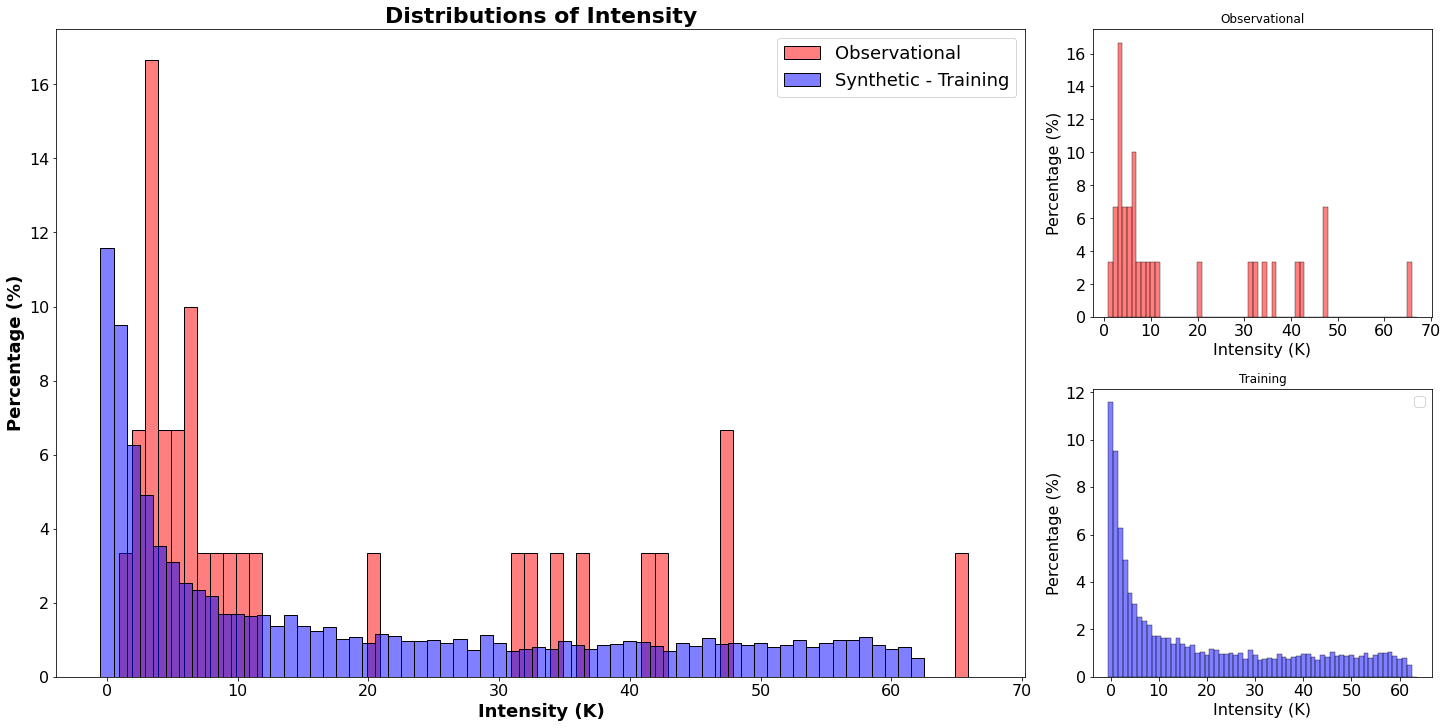

In [62]:
import matplotlib.pyplot as plt
fig = plt.figure(constrained_layout=True, figsize=(20, 10))
axs = fig.subplot_mosaic([['Left', 'TopRight'],['Left', 'BottomRight']],
                          gridspec_kw={'width_ratios':[20, 7]})

# plot the df_obs data as distributions in the left plot
sns.histplot(df_obs['T(K)'], label='Observational', color='red', stat='percent', discrete=True, fill=True, alpha=0.5, ax=axs['Left'])  
sns.histplot(df_max_inten['T(K)'], label='Synthetic - Training', color='blue', stat='percent', discrete=True, fill=True,  alpha=0.5, ax=axs['Left'])
axs['Left'].set_title('Observational', fontsize=22, fontweight='bold')
axs['Left'].set_xlabel('Intensity (K)', fontsize=18, fontweight='bold')
axs['Left'].set_ylabel('Percentage (%)', fontsize=18, fontweight='bold')               
axs['Left'].set_title('Distributions of Intensity', fontsize=22, fontweight='bold')
# add a legend
axs['Left'].legend(loc='upper right', fontsize=18)


sns.histplot(df_obs['T(K)'], color='red', stat='percent', discrete=True, fill=True,  alpha=0.5, ax=axs['TopRight']) 
axs['TopRight'].set_title('Observational')
axs['TopRight'].set_xlabel('Intensity (K)', fontsize=16)
axs['TopRight'].set_ylabel('Percentage (%)', fontsize=16) 
# annotate the max and min values of the observational data
# axs['TopRight'].annotate('Max: ' + str(df_obs['T(K)'].max()), xy=(df_obs['T(K)'].max(), 0.1), xytext=(df_obs['T(K)'].max(), 0.1), fontsize=16)

sns.histplot(df_max_inten['T(K)'], color='blue', stat='percent', discrete=True, alpha=0.5, ax=axs['BottomRight'])
axs['BottomRight'].set_title('Training')
axs['BottomRight'].set_xlabel('Intensity (K)', fontsize=16)
axs['BottomRight'].set_ylabel('Percentage (%)', fontsize=16) 
# annotate the max and min values of the synthetic data
# axs['BottomRight'].annotate('Max: ' + str(df_synth['T(K)'].max()), xy=(df_synth['T(K)'].max(), 0.5), xytext=(df_synth['T(K)'].max(), 0.5), fontsize=16)
plt.legend(loc='upper right', fontsize=14)

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)


plt.savefig(CH3CH_DATA_OUTPUT_PATH + 'observational_synth_max_intensity_distribution_no_kde.pdf', dpi=100)